#### Human Protein Exploration

Using reference from this kernel https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/71039

In [1]:
import fastai
fastai.__version__

'1.0.28'

In [2]:
from fastai import *
from fastai.vision import *
from fastai.vision.image import *
import torch
import torch.nn as nn
import torchvision
import cv2
import scipy.optimize as opt

In [3]:
np.random.seed(42)

In [4]:
path = Path('data')

In [5]:
path.ls()

[PosixPath('data/first-submission.csv'),
 PosixPath('data/focal-loss-submission-384-unfreeze.csv'),
 PosixPath('data/focal_loss_gamma_0.25_512_unfreeze.csv'),
 PosixPath('data/unfreeze_resnet101_512_avg_preds_v1.csv'),
 PosixPath('data/threasholded_manual.csv'),
 PosixPath('data/threasholded.csv'),
 PosixPath('data/first-submission-384.csv'),
 PosixPath('data/train.csv'),
 PosixPath('data/resnet101_512_avg_preds.csv'),
 PosixPath('data/focal_loss_gamma_0.25_512_unfreeze-no-tta.csv'),
 PosixPath('data/train-0.csv'),
 PosixPath('data/focal-loss-submission-384-tmp.csv'),
 PosixPath('data/models'),
 PosixPath('data/resnet101_512.csv'),
 PosixPath('data/unfreeze_resnet152_386_avg_preds_v1.csv'),
 PosixPath('data/unfreeze_resnet152_386_preds_v1.csv'),
 PosixPath('data/test'),
 PosixPath('data/unfreeze_resnet152_512_avg_pred_v1.csv'),
 PosixPath('data/first-submission-512.csv'),
 PosixPath('data/.ipynb_checkpoints'),
 PosixPath('data/unfreeze_resnet101_512_avg_preds_v3.csv'),
 PosixPath('data

In [6]:
train_df = pd.read_csv(path / 'train.csv')

In [7]:
train_df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [8]:
RESNET_ENCODERS = {
    34: torchvision.models.resnet34,
    50: torchvision.models.resnet50,
    101: torchvision.models.resnet101,
    152: torchvision.models.resnet152,
}

In [9]:
class Resnet4Channel(nn.Module):
    
    def __init__(self, encoder_depth=34, pretrained=True, num_classes=28):
        super().__init__()
        encoder = RESNET_ENCODERS[encoder_depth](pretrained=pretrained)
        w = encoder.conv1.weight
        
#         (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
#         (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#         (relu): ReLU(inplace)
#         (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        
        self.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.conv1.weight = nn.Parameter(torch.cat((w, torch.zeros(64, 1, 7, 7)), dim=1))
        self.bn1 = encoder.bn1
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        
        self.layer1 = encoder.layer1
        self.layer2 = encoder.layer2
        self.layer3 = encoder.layer3
        self.layer4 = encoder.layer4
        
        self.avgpool = encoder.avgpool
        self.fc = nn.Linear(512 * (1 if encoder_depth == 34 else 4), num_classes)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [10]:
def open_4_channel(fname):
    fname = str(fname)
    if fname.endswith(".png"):
        fname = fname[:-4]
        
    colors = ['red', 'green', 'blue', 'yellow']
    flags = cv2.IMREAD_GRAYSCALE
    
    img = [cv2.imread(fname + '_' + color + '.png', flags).astype(np.float32) / 255 for color in colors]
    
    x = np.stack(img, axis=-1)
    
    return Image(pil2tensor(x, np.float32).float())

In [11]:
src = (ImageItemList.from_csv(path, 'train.csv', folder='train', suffix='.png')
      .random_split_by_pct(0.2)
      .label_from_df(sep=' ', classes=[str(i) for i in range(28)]))

In [12]:
src.train.x.open = open_4_channel
src.train.x.create_func = open_4_channel

In [13]:
src.valid.x.open = open_4_channel
src.valid.x.create_func = open_4_channel

In [14]:
test_ids = list(sorted(set(fname.split('_')[0] for fname in os.listdir(path / 'test'))))

In [15]:
test_fnames = [path/'test'/test_id for test_id in test_ids]

In [16]:
test_fnames[:5]

[PosixPath('data/test/00008af0-bad0-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('data/test/0000a892-bacf-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('data/test/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0'),
 PosixPath('data/test/0008baca-bad7-11e8-b2b9-ac1f6b6435d0'),
 PosixPath('data/test/000cce7e-bad4-11e8-b2b8-ac1f6b6435d0')]

In [17]:
src.add_test(test_fnames, label='0');

In [18]:
src.test.x.open = open_4_channel
src.test.x.create_func = open_4_channel

In [19]:
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

In [20]:
trn_tfms, _ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1, max_lighting=0.05, max_warp=0.)

In [21]:
data = (src.transform((trn_tfms, _), size=512).databunch(bs=16).normalize(protein_stats))

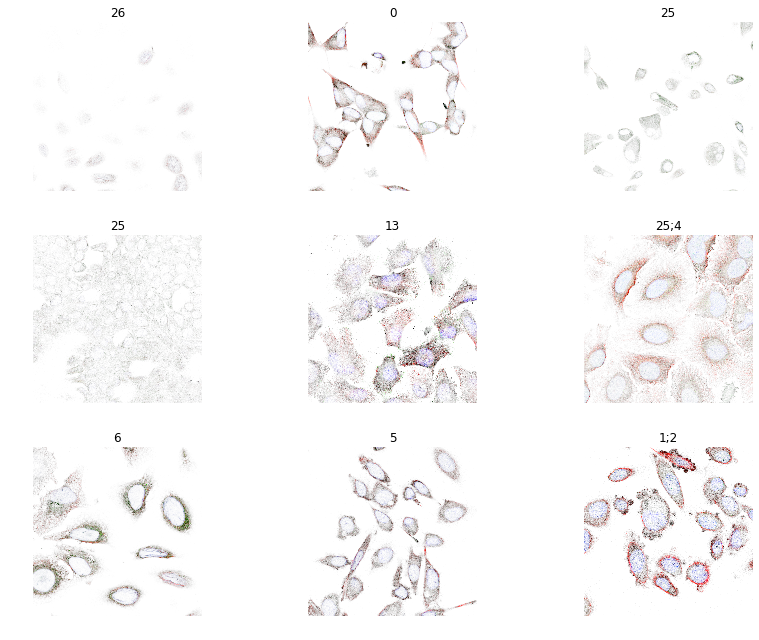

In [22]:
data.show_batch(rows=3, figsize=(12,9))

In [23]:
def resnet50(pretrained):
    return Resnet4Channel(encoder_depth=50)

In [24]:
def resnet101(pretrained):
    return Resnet4Channel(encoder_depth=101)

In [25]:
def _resnet_split(m): return (m[0][6],m[1])

In [26]:
f1_score = partial(fbeta, thresh=0.2, beta=1)

In [27]:
learn = create_cnn(
    data,
    resnet101,
    cut=-2,
    split_on=_resnet_split,
    loss_func=F.binary_cross_entropy_with_logits,
    path=path,    
    metrics=[f1_score], 
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


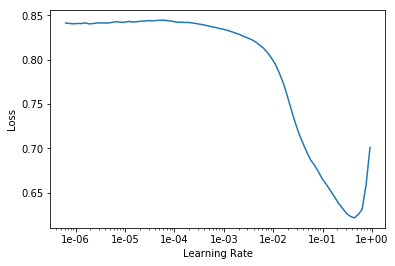

In [28]:
learn.lr_find()
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(6, 2e-2)

Total time: 30:31
epoch  train_loss  valid_loss  fbeta   
1      0.136575    0.137073    0.490605  (05:09)
2      0.133267    0.153205    0.457749  (05:08)
3      0.126814    0.130124    0.542584  (05:04)
4      0.114821    0.112550    0.605931  (05:00)
5      0.111290    0.103641    0.641295  (05:01)
6      0.103768    0.101363    0.646691  (05:06)



In [30]:
learn.save("freeze_224_resnet101")

In [35]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


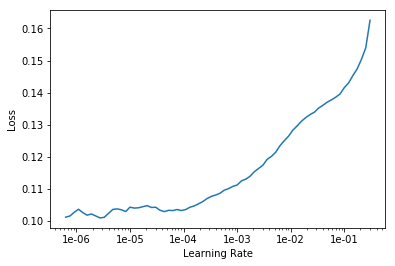

In [36]:
learn.lr_find()
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(6, slice(1e-6, 1e-4 / 5 ))

Total time: 31:30
epoch  train_loss  valid_loss  fbeta   
1      0.104758    0.101022    0.648574  (05:11)
2      0.104460    0.100616    0.650823  (05:13)
3      0.103587    0.100128    0.655201  (05:18)
4      0.103694    0.099838    0.653918  (05:14)
5      0.104328    0.099442    0.655549  (05:16)
6      0.102301    0.099456    0.654487  (05:16)



In [38]:
learn.fit_one_cycle(10, slice(1e-7, 1e-5))

Total time: 53:08
epoch  train_loss  valid_loss  fbeta   
1      0.102311    0.099915    0.652767  (05:18)
2      0.103341    0.099318    0.654074  (05:18)
3      0.102815    0.099380    0.654776  (05:17)
4      0.101333    0.099376    0.653457  (05:17)
5      0.102702    0.099125    0.657716  (05:16)
6      0.101129    0.099056    0.654418  (05:17)
7      0.101915    0.098995    0.657990  (05:19)
8      0.101281    0.099032    0.656096  (05:20)
9      0.101308    0.099026    0.656073  (05:21)
10     0.100607    0.098826    0.656295  (05:22)



In [39]:
learn.save("unfreeze_224_resnet101")

In [28]:
_ = learn.load("unfreeze_224_resnet101")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


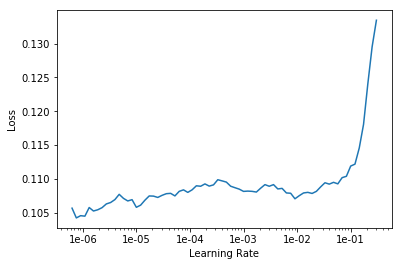

In [29]:
learn.lr_find()
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(6, 3e-3)

Total time: 1:00:15
epoch  train_loss  valid_loss  fbeta   
1      0.099696    0.092915    0.677834  (10:05)
2      0.101334    0.092832    0.680725  (10:01)
3      0.095990    0.090278    0.691957  (10:02)
4      0.090607    0.090406    0.700133  (10:00)
5      0.090276    0.087897    0.707914  (10:02)
6      0.088213    0.090745    0.709072  (10:03)



In [32]:
learn.save("freeze_386_resnet101")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


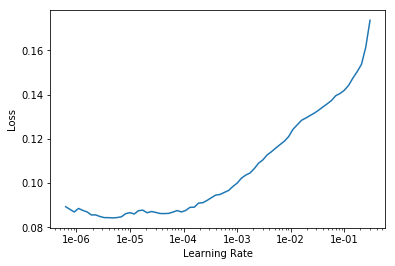

In [31]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [33]:
learn.fit_one_cycle(6, 2e-5)

Total time: 1:17:08
epoch  train_loss  valid_loss  fbeta   
1      0.090475    0.086352    0.706165  (12:50)
2      0.091667    0.088962    0.697434  (12:50)
3      0.089151    0.090235    0.700599  (12:52)
4      0.086968    0.089178    0.714496  (12:51)
5      0.084660    0.082154    0.722509  (12:52)
6      0.085067    0.081107    0.723728  (12:51)



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


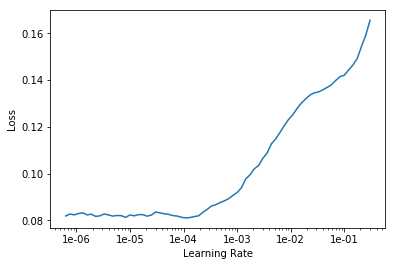

In [35]:
learn.lr_find()
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(6, slice(1e-6, 5e-5))

Total time: 1:15:44
epoch  train_loss  valid_loss  fbeta   
1      0.081996    0.089179    0.721830  (12:45)
2      0.082289    0.082498    0.725900  (12:35)
3      0.086542    0.081849    0.726320  (12:38)
4      0.081775    0.087295    0.729862  (12:33)
5      0.082182    0.087404    0.727354  (12:32)
6      0.079892    0.087446    0.727943  (12:39)



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


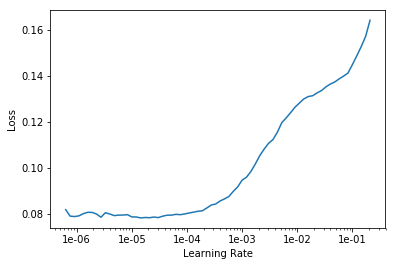

In [32]:
learn.lr_find()
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(8, slice(1e-6, 5e-3))

Total time: 1:40:50
epoch  train_loss  valid_loss  fbeta   
1      0.087860    0.085494    0.715709  (12:34)
2      0.092818    0.095359    0.670584  (12:30)
3      0.094466    0.167873    0.681225  (12:32)
4      0.094949    0.088963    0.705382  (12:35)
5      0.087413    0.111777    0.713122  (12:37)
6      0.081389    0.091387    0.728460  (12:39)
7      0.077211    0.078991    0.730686  (12:39)
8      0.075119    0.077482    0.734999  (12:39)



In [36]:
learn.fit_one_cycle(8, slice(1e-6, 5e-3))

Total time: 1:41:17
epoch  train_loss  valid_loss  fbeta   
1      0.080197    0.790475    0.714458  (12:38)
2      0.085603    0.248532    0.701883  (12:38)
3      0.086786    0.087911    0.705268  (12:39)
4      0.088067    0.084364    0.717949  (12:39)
5      0.081962    0.084353    0.717808  (12:40)
6      0.077901    0.079622    0.736626  (12:39)
7      0.073308    0.075902    0.746737  (12:39)
8      0.070692    0.074882    0.748186  (12:40)



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


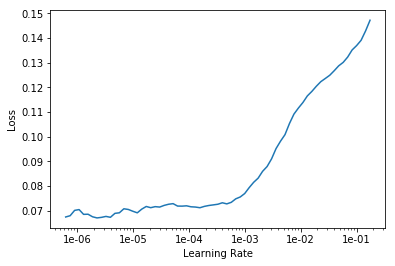

In [38]:
learn.lr_find()
learn.recorder.plot()

In [39]:
learn.fit_one_cycle(12, slice(1e-6, 5e-3))

Total time: 2:32:01
epoch  train_loss  valid_loss  fbeta   
1      0.071635    0.078527    0.735015  (12:39)
2      0.078317    0.090460    0.725389  (12:37)
3      0.083506    0.086101    0.715952  (12:40)
4      0.084326    0.086146    0.705172  (12:40)
5      0.084214    0.087682    0.720410  (12:40)
6      0.080669    0.079292    0.726659  (12:39)
7      0.078558    0.111987    0.732246  (12:40)
8      0.072315    0.139587    0.745682  (12:40)
9      0.070953    0.074176    0.746636  (12:41)
10     0.066370    0.079552    0.752138  (12:41)
11     0.064920    0.127460    0.751877  (12:39)
12     0.062505    0.102274    0.754853  (12:40)



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


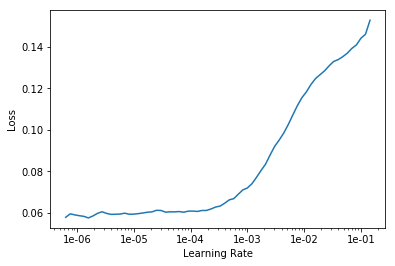

In [41]:
learn.lr_find()
learn.recorder.plot()

In [42]:
learn.fit_one_cycle(12, slice(1e-6, 5e-3))

Total time: 2:31:58
epoch  train_loss  valid_loss  fbeta   
1      0.063448    0.125483    0.750339  (12:37)
2      0.071163    0.084795    0.738885  (12:37)
3      0.076172    0.100291    0.725787  (12:38)
4      0.078279    0.081415    0.717185  (12:40)
5      0.077895    0.083243    0.724965  (12:40)
6      0.076043    0.093372    0.724893  (12:40)
7      0.073152    0.107190    0.726958  (12:40)
8      0.069503    0.074988    0.750236  (12:40)
9      0.065594    0.100361    0.753670  (12:40)
10     0.061793    0.120159    0.756428  (12:41)
11     0.056475    0.108291    0.758533  (12:40)
12     0.057500    0.117417    0.761134  (12:40)



In [45]:
learn.save("unfreeze_386_resnet101")

In [46]:
learn.fit_one_cycle(20, slice(1e-6, 5e-3))

Total time: 4:13:18
epoch  train_loss  valid_loss  fbeta   
1      0.055634    0.102583    0.758289  (12:36)
2      0.061169    0.081293    0.751267  (12:37)
3      0.064100    0.102468    0.754017  (12:38)
4      0.065898    0.082415    0.737053  (12:39)
5      0.066611    0.102190    0.724454  (12:38)
6      0.069391    0.082742    0.725089  (12:38)
7      0.071828    0.078791    0.738645  (12:40)
8      0.072632    0.080144    0.737187  (12:39)
9      0.068415    0.094284    0.743112  (12:41)
10     0.068145    0.082155    0.730506  (12:40)
11     0.067326    0.081160    0.741354  (12:40)
12     0.062079    0.077690    0.749784  (12:40)
13     0.058202    0.076539    0.752856  (12:40)
14     0.054425    0.074713    0.760458  (12:39)
15     0.051755    0.076128    0.760962  (12:41)
16     0.049556    0.074514    0.761664  (12:41)
17     0.045647    0.075874    0.762836  (12:40)
18     0.045960    0.076142    0.765044  (12:41)
19     0.041510    0.075590    0.767664  (12:41)
20     0.

In [48]:
learn.save("unfreeze_386_resnet101-2")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


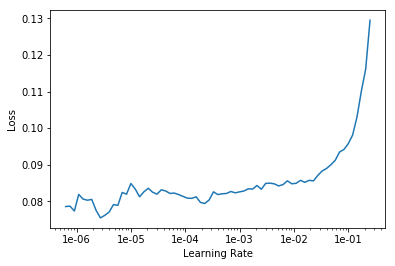

In [29]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(8, 5e-3)

Total time: 1:59:10
epoch  train_loss  valid_loss  fbeta   
1      0.073562    0.116792    0.741877  (14:58)
2      0.079890    0.097485    0.721082  (14:52)
3      0.087066    0.089754    0.715209  (14:52)
4      0.080146    0.088908    0.711306  (14:49)
5      0.077707    0.082352    0.728067  (14:54)
6      0.072848    0.076585    0.748737  (14:55)
7      0.067647    0.073485    0.755316  (14:54)
8      0.064702    0.073662    0.759842  (14:53)



In [32]:
learn.save("freeze_512_resnet101")

In [28]:
_ = learn.load("freeze_512_resnet101")
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


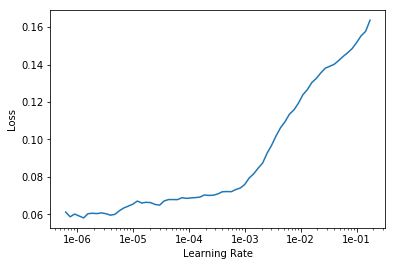

In [29]:
learn.lr_find()
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(20, slice(1e-6, 5e-3))

Total time: 6:22:51
epoch  train_loss  valid_loss  fbeta   
1      0.072136    0.075416    0.750654  (19:15)
2      0.069966    0.077465    0.746969  (19:07)
3      0.075965    0.079870    0.730500  (19:06)
4      0.083958    0.079417    0.731514  (19:06)
5      0.083808    0.080122    0.729563  (19:06)
6      0.084100    0.082306    0.726883  (19:06)
7      0.085555    0.084100    0.719580  (19:07)
8      0.081585    0.081361    0.723393  (19:08)
9      0.084276    0.082183    0.722915  (19:09)
10     0.081009    0.079082    0.730992  (19:08)
11     0.078452    0.078481    0.743691  (19:08)
12     0.073369    0.078102    0.748479  (19:09)
13     0.072234    0.074851    0.754005  (19:08)
14     0.069501    0.074795    0.756358  (19:08)
15     0.061866    0.075237    0.759140  (19:08)
16     0.059526    0.074667    0.762101  (19:07)
17     0.056747    0.071994    0.768176  (19:08)
18     0.054048    0.072060    0.767453  (19:09)
19     0.055409    0.073292    0.768198  (19:09)
20     0.

In [31]:
learn.save("unfreeze_512_resnet101")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


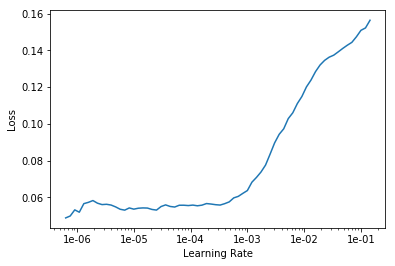

In [32]:
learn.lr_find()
learn.recorder.plot()

In [33]:
learn.fit_one_cycle(8, slice(1e-6, 5e-4))

Total time: 2:33:04
epoch  train_loss  valid_loss  fbeta   
1      0.056660    0.073839    0.765560  (19:06)
2      0.054453    0.074036    0.759423  (19:07)
3      0.058668    0.073757    0.765436  (19:08)
4      0.055803    0.072601    0.766834  (19:08)
5      0.057307    0.073140    0.765627  (19:07)
6      0.054932    0.072776    0.769260  (19:08)
7      0.050984    0.072928    0.772971  (19:08)
8      0.052085    0.072280    0.767745  (19:08)



In [34]:
learn.save("unfreeze_512_resnet101-2")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


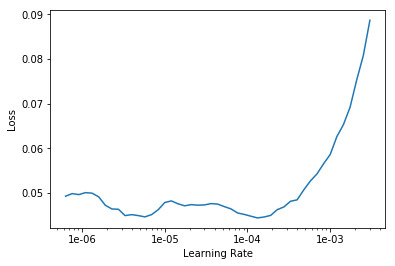

In [35]:
learn.lr_find()
learn.recorder.plot()

In [36]:
learn.fit_one_cycle(8, slice(1e-6, 1e-4))

Total time: 2:33:34
epoch  train_loss  valid_loss  fbeta   
1      0.050007    0.073227    0.767154  (19:11)
2      0.054657    0.073493    0.771943  (19:09)
3      0.052246    0.073508    0.764117  (19:09)
4      0.052636    0.073170    0.766186  (19:13)
5      0.050337    0.072898    0.769791  (19:10)
6      0.049697    0.072692    0.769815  (19:09)
7      0.047313    0.073517    0.766993  (19:14)
8      0.049270    0.073784    0.767445  (19:16)



In [37]:
learn.fit_one_cycle(8, slice(1e-8, 1e-6))

Total time: 2:33:27
epoch  train_loss  valid_loss  fbeta   
1      0.043725    0.073154    0.765984  (19:09)
2      0.052384    0.073216    0.768585  (19:08)
3      0.046929    0.073650    0.772918  (19:12)
4      0.047623    0.073657    0.769590  (19:12)
5      0.048079    0.074632    0.769773  (19:11)
6      0.047922    0.073062    0.767802  (19:11)
7      0.047702    0.074071    0.768428  (19:10)
8      0.047817    0.073994    0.772460  (19:10)



In [38]:
learn.save("unfreeze_512_resnet101-3")

In [46]:
_ = learn.load("unfreeze_512_resnet101")

In [47]:
preds, avg_pred, y = learn.TTA(beta=None, scale=1.05, ds_type=DatasetType.Test)

Total time: 41:04



In [48]:
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row > 0.2)[0]])) for row in np.array(avg_pred)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'unfreeze_resnet101_512_avg_preds_v1.csv', header=True, index=False)
df.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5 25
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 5 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 25
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0 7 23 25


In [34]:
# preds,_ = learn.get_preds(DatasetType.Test)

/home/deep/fastai-env/lib/python3.6/site-packages/torch/nn/functional.py:1174: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [35]:
# pred_labels = [' '.join(list([str(i) for i in np.nonzero(row > 0.2)[0]])) for row in np.array(preds)]
# df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
# df.to_csv(path/'resnet101_512.csv', header=True, index=False)
# df.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5 25
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 5 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0 23 25


##### TTA scores

In [33]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

preds, avg_pred, y = learn.TTA(beta=None, scale=1.05, ds_type=DatasetType.Test)

Total time: 40:36



In [34]:
preds.shape

torch.Size([11702, 28])

In [35]:
avg_pred.shape

torch.Size([11702, 28])

In [36]:
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row > 0.2)[0]])) for row in np.array(avg_pred)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'resnet101_512_avg_preds.csv', header=True, index=False)
df.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 5 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 25
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0 7 25


In [41]:
beta = 0.4
final_preds = preds*beta + avg_pred*(1-beta)

In [42]:
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row > 0.2)[0]])) for row in np.array(final_preds)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'resnet101_512_final_preds.csv', header=True, index=False)
df.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 5 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 25
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0 7 25


In [43]:
#### avg_preds performed much better!

##### Threasholding

In [44]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

preds, avg_pred, y = learn.TTA(beta=None, scale=1.05)

Total time: 22:01



In [45]:
preds_, avg_pred_, y_ = preds.numpy(), avg_pred.numpy(), y.numpy()

In [59]:
# F1 score based on Kaggle Kernel
def F1_soft(preds, targs, th=0.5, d=50.0):
    preds = sigmoid_np( d * (preds - th))
    targs = targs.astype(np.float)

    score = 2.0 * (preds * targs).sum(axis=1) / ((preds + targs).sum(axis=1) + 1e-9)
    return score

# F1 score based on Fastai matrix
def fbeta2(y_pred, y_true, thresh=0.2, beta=1, eps=1e-9, sigmoid=False):
    beta2 = beta**2
    if sigmoid: y_pred = y_pred.sigmoid()
    y_pred = (y_pred>thresh).float()
    y_true = y_true.float()
    TP = (y_pred*y_true).sum(dim=1)
    prec = TP/(y_pred.sum(dim=1)+eps)
    rec = TP/(y_true.sum(dim=1)+eps)
    res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)
    return res.mean()

def fit_val(x,y):
    params = 0.5 * np.ones(28)
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x, y, p) - 1.0, wd * (p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [63]:
th = fit_val(avg_pred_, y_)
th[th < 0.1] = 0.1
print('Thresholds: ', th)

th_gpu = th.copy()
th_gpu = torch.FloatTensor(th_gpu)

print('F1 macro: ', fbeta2(avg_pred, y, th_gpu))
print('F1 macro (th = 0.2): ', fbeta2(avg_pred, y, 0.2))
print('F1 macro (th = 0.5): ', fbeta2(avg_pred, y, 0.5))

print('F1 macro: ', fbeta2(preds, y, th_gpu))
print('F1 macro (th = 0.2): ', fbeta2(preds, y, 0.2))
print('F1 macro (th = 0.5): ', fbeta2(preds, y, 0.5))

Thresholds:  [0.219664 0.167961 0.257473 0.199919 0.22539  0.186263 0.168383 0.193929 0.221295 0.181471 0.314688 0.164075 0.183212
 0.236929 0.15789  8.697891 0.449306 0.479556 0.227879 0.156333 0.408823 0.15917  0.218963 0.145534 0.438345 0.200315
 0.355311 0.304825]
F1 macro:  tensor(0.7679)
F1 macro (th = 0.2):  tensor(0.7672)
F1 macro (th = 0.5):  tensor(0.7318)
F1 macro:  tensor(0.7606)
F1 macro (th = 0.2):  tensor(0.7598)
F1 macro (th = 0.5):  tensor(0.7325)


In [64]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

preds_test, avg_pred_test, y_test = learn.TTA(beta=None, scale=1.05, ds_type=DatasetType.Test)

Total time: 41:02



In [65]:
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row > th)[0]])) for row in np.array(avg_pred_test)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'resnet101_512_avg_preds_threshold.csv', header=True, index=False)
df.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 5 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 25
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0 7 23 25


In [ ]:
# def calc_threshold(pred):
#     threshold_dict = dict()
#     for idx in tqdm(range(28)):
#         m = 0
#         for ii in range(100):
#             threshold0 = ii * 0.01
#             f1_val = f1_score(y_cat_train_dic[idx], threshold0 < (pred[:,idx]))
#             if m < f1_val:
#                 threshold_dic[idx] = threshold0+0.005
#                 m = f1_val
#     return threshold_dic